In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F

In [2]:
os.listdir("/kaggle/input/kdd-cup-1999-data")

['kddcup.data.gz',
 'kddcup.data',
 'kddcup.testdata.unlabeled',
 'training_attack_types',
 'kddcup.data.corrected',
 'kddcup.newtestdata_10_percent_unlabeled.gz',
 'corrected',
 'kddcup.testdata.unlabeled.gz',
 'kddcup.testdata.unlabeled_10_percent',
 'corrected.gz',
 'kddcup.newtestdata_10_percent_unlabeled',
 'kddcup.data_10_percent.gz',
 'kddcup.names',
 'kddcup.data_10_percent_corrected',
 'typo-correction.txt',
 'kddcup.data_10_percent',
 'kddcup.testdata.unlabeled_10_percent.gz']

In [3]:
!cat /kaggle/input/kdd-cup-1999-data/kddcup.names

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: con

In [4]:
col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
             'dst_bytes','land', 'wrong_fragment', 'urgent', 'hot', 
             'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
             'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
             'num_access_files', 'num_outbound_cmds', 'is_host_login', 
             'is_guest_login', 'count', 'srv_count', 'serror_rate', 
             'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
             'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
             'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
             'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
             'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
             'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
             'dst_host_srv_rerror_rate', 'label']

In [5]:
df = pd.read_csv('/kaggle/input/kdd-cup-1999-data/kddcup.data.gz', names=col_names)

In [6]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
df.shape

(4898431, 42)

In [8]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [9]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [10]:
df['label'].value_counts()

label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64

In [11]:
df['label'].nunique()

23

In [12]:
num_cols = df._get_numeric_data().columns

cate_cols = list(set(df.columns)-set(num_cols))

cate_cols

['flag', 'service', 'label', 'protocol_type']

In [13]:
df[cate_cols]

,flag,service,label,protocol_type
0,SF,http,normal.,tcp
1,SF,http,normal.,tcp
2,SF,http,normal.,tcp
3,SF,http,normal.,tcp
4,SF,http,normal.,tcp
...,...,...,...,...
4898426,SF,http,normal.,tcp
4898427,SF,http,normal.,tcp
4898428,SF,http,normal.,tcp
4898429,SF,http,normal.,tcp


In [14]:
# Make a copy of the initial dataframe so we can use different approach later
init_df = df.copy()

In [15]:
for category in cate_cols:
    print(df[category].value_counts())

flag
SF        3744328
S0         869829
REJ        268874
RSTR         8094
RSTO         5344
SH           1040
S1            532
S2            161
RSTOS0        122
OTH            57
S3             50
Name: count, dtype: int64
service
ecr_i        2811660
private      1100831
http          623091
smtp           96554
other          72653
              ...   
tftp_u             3
harvest            2
aol                2
http_8001          2
http_2784          1
Name: count, Length: 70, dtype: int64
label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule. 

In [16]:
category_mapping = {}
# Convert the non numerical values into numeric values via categorization e.g. TCP - 1, UDP -2 ...
for category in cate_cols:
    labels, unique_values = pd.factorize(df[category])
    df[category] = labels
    category_mapping[category] = dict(zip(set(unique_values), set(labels)))

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,0,0,0,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0


In [17]:
category_mapping

{'flag': {'RSTOS0': 0,
  'RSTR': 1,
  'S1': 2,
  'SH': 3,
  'S0': 4,
  'S3': 5,
  'OTH': 6,
  'REJ': 7,
  'SF': 8,
  'S2': 9,
  'RSTO': 10},
 'service': {'systat': 0,
  'auth': 1,
  'printer': 2,
  'daytime': 3,
  'pm_dump': 4,
  'gopher': 5,
  'hostnames': 6,
  'uucp_path': 7,
  'sunrpc': 8,
  'tftp_u': 9,
  'eco_i': 10,
  'ftp_data': 11,
  'login': 12,
  'other': 13,
  'efs': 14,
  'nnsp': 15,
  'red_i': 16,
  'aol': 17,
  'rje': 18,
  'IRC': 19,
  'http_2784': 20,
  'courier': 21,
  'private': 22,
  'ntp_u': 23,
  'name': 24,
  'exec': 25,
  'vmnet': 26,
  'http': 27,
  'ftp': 28,
  'time': 29,
  'uucp': 30,
  'kshell': 31,
  'urp_i': 32,
  'harvest': 33,
  'smtp': 34,
  'http_8001': 35,
  'urh_i': 36,
  'domain_u': 37,
  'discard': 38,
  'link': 39,
  'X11': 40,
  'pop_3': 41,
  'ldap': 42,
  'mtp': 43,
  'http_443': 44,
  'telnet': 45,
  'netbios_ssn': 46,
  'sql_net': 47,
  'csnet_ns': 48,
  'iso_tsap': 49,
  'klogin': 50,
  'netstat': 51,
  'ctf': 52,
  'imap4': 53,
  'pop_2': 5

In [18]:
for category in cate_cols:
    print(df[category].value_counts())

flag
0     3744328
7      869829
5      268874
8        8094
6        5344
10       1040
2         532
1         161
9         122
4          57
3          50
Name: count, dtype: int64
service
9     2811660
12    1100831
0      623091
1       96554
10      72653
       ...   
66          3
64          2
65          2
67          2
63          1
Name: count, Length: 70, dtype: int64
label
5     2807886
4     1072017
0      972781
15      15892
10      12481
9       10413
17       2316
13       2203
20       1020
8         979
7         264
6          53
1          30
11         21
19         20
14         12
22         10
2           9
12          8
18          7
16          4
3           3
21          2
Name: count, dtype: int64
protocol_type
2    2833545
0    1870598
1     194288
Name: count, dtype: int64


<Axes: >

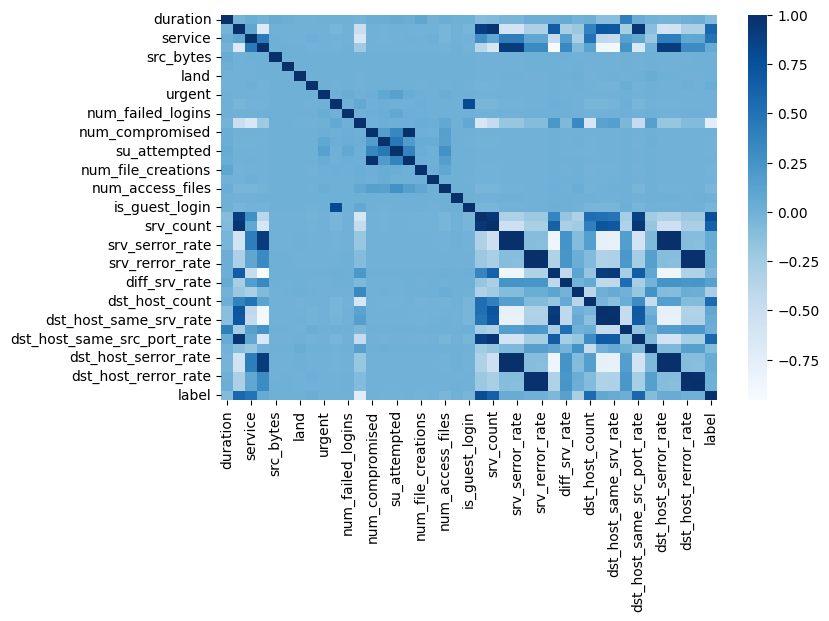

In [19]:
df = df[[col for col in df if df[col].nunique() > 1]]# keep columns where there are more than 1 unique values

corr = df.corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr, cmap='Blues')

In [20]:
X = torch.tensor(df.drop('label',axis=1).values)
y = torch.tensor(df['label'].values)
X,y

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0000, 0.0000]],
        dtype=torch.float64),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [21]:
X.shape

torch.Size([4898431, 40])

In [22]:
dataset = TensorDataset(X,y)

In [23]:
def pct_to_val(train_pct,data):
    '''Helper function to make code cleaer.
        changes percentage split into numbers of data.
        INPUTS:
        train_pct: the percentage of training data 
        valid_pct: the percentage of validation data
        data: the dataset
        returns: numbers of data'''
    train_num = int(train_pct/100*len(data))
    valid_num = int(len(data) - train_num)
    return train_num , valid_num

In [24]:
train_num,valid_num = pct_to_val(85,dataset)
# Get traning and validation datasets.
train_ds,valid_ds = random_split(dataset,[train_num,valid_num])
# Make a dataloader
BATCH = 264
train_dl = DataLoader(train_ds,batch_size=BATCH,shuffle=True)
valid_dl = DataLoader(valid_ds,batch_size=BATCH,shuffle=True)

In [25]:
device = torch.device('cuda') if torch.cuda.is_available else 'cpu'

def to_device(data, device):
    if isinstance(data,(list,tuple)):
        return [to_device(d,device) for d in data]
    return data.to(device,non_blocking = True)

In [26]:
class DeviceDL():
    
    def __init__(self,dl,dev):
        self.dl = dl
        self.dev = dev
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch,self.dev)
            
    def __len__(self):
        return len(self.dl)

In [27]:
train_dl = DeviceDL(train_dl,device)
valid_dl = DeviceDL(valid_dl,device)

In [28]:
def accuracy(label, preds):
    return torch.sum(torch.round(preds) == label) / len(label)

In [29]:
class BaseNet(nn.Module):
    def get_loss(self, batch, loss_fn):
        features,labels = batch
        preds = self(features)
        loss = loss_fn(preds,labels)
        return loss
    
    def validate(self, batch, loss_fn):
        feature, labels = batch
        loss = self.get_loss(batch,loss_fn)
        pred = self(feature)
        
        acc = accuracy(labels,pred)
        return {'valid_loss' : loss , 'valid_acc' : acc}
    
    def average_validation(self, out):
        loss = torch.stack([l['valid_loss'] for l in out]).mean()
        acc = torch.stack([l['valid_acc'] for l in out]).mean()
        return {'valid_loss': loss.item() , 'valid_acc': acc.item()}
    
    def log_epoch(self,e,epoch,res):
        
        print('[{} / {}] epoch/s, training loss is {:.4f} validation loss is {:.4f}, validation accuracy is {:.4f} '\
              .format(e+1,epoch,
                      res['train_loss'],
                      res['valid_loss'],                
                      res['valid_acc']
                     )
             )

In [30]:
class ClassifierMLP(BaseNet):
    
    def __init__(self, activation, input_dim, hidden_1, hidden_2, hidden_3, out):
        self.hidden_1 = nn.Linear(input_dim, hidden_1)
        self.hidden_2 = nn.Linear(hidden_1, hidden_2)
        self.hidden_3 = nn.linear(hidden_2, hidden_3)
        self.out = nn.linear(hidden_3, out)
        self.activation = activation
        
    def forward(self, x):
        x1 = self.hidden_1(x)
        x2 = self.activation(x1)
        x3 = self.hidden_2(x2)
        x4 = self.activation(x3)
        x5 = self.hidden_3(x4)
        x6 = self.activation(x5)
        x7 = self.out(x6)
#         Note in pytorch we don't apply activation in final layer or use softmax because cross entropy
# loss function would do it automatically under the hood, we will rather only use softmax when interpreting
# the results in a human readable form. (not even while testing)
        return out
        
        

In [ ]:
init_df['label'] = df['label'].replace(['back.', 'land.', 'neptune.', 'pod.','smurf.', 'teardrop.', 'apache2.','udpstorm.','processtable.', 'worm.'], '1') 
#10 DoS

init_df['label'] = df['label'].replace(['satan.', 'ipsweep.', 'nmap.', 'portsweep.', 'mscan.', 'saint.'], '2') 
#6 Probe

init_df['label'] = df['label'].replace(['guess_passwd.', 'ftp_write.', 'imap.', 'phf.', 'multihop.', 'warezmaster.', 'warezclient.', 'spy.', 'xlock.', 'xsnoop.', 'snmpguess.', 'snmpgetattack.', 'httptunnel.', 'sendmail.', 'named.', 'mailbomb.'], '3') 
#16 R2L

init_df['label'] = df['label'].replace(['buffer_overflow.', 'loadmodule.', 'rootkit.', 'perl.', 'sqlattack.', 'xterm.', 'ps.'], '4') 
#7 U2R

init_df['label'] = df['label'].replace('normal.', '0')